In [131]:
import pandas as pd
import re

In [132]:
# get today's over/under for each team from draftkings
df = pd.read_html("https://sportsbook.draftkings.com/leagues/basketball/nba")

# potential problem could occur if draft kings changes format of their html
df = df[0]

In [133]:
# function to separate date from team name
def split_team_name(team_and_date_long_string):
    """Splits up the messy "tomorrow" column from our scraped Draft Kings Data.
    Returns time, team abbreviation, and team name."""


    # find date - should be any characters ending with AM or PM
    # NOTE: game times appear to be 5 hours ahead of EST
    # not an issue unless we choose to implement this as a feature
    time = re.search(r'(.+)(AM|PM)', team_and_date_long_string)
    if not time:
        # if game is in progress, ignore
        return None, None, None
    
    time = time[0]
    # find team name - all characters after the date
    team = re.search(r'(.+)(AM|PM)(.+)', team_and_date_long_string)[3]

    # split abbreviation and team name
    team_abbrev = team.split(' ')[0]
    team_full = team.split(' ')[1]

    return time, team_abbrev, team_full

df[["time", "team_abbrev", "team_full"]] = df.apply(lambda x: split_team_name(x["Today"]), axis=1, result_type="expand")
df.dropna(inplace=True)

In [134]:
# convert team abbrev to 3 letters if its not

def expand_abbrev(abbrev, name):
    if name == "Lakers":
        return 'LAL'
    if name == "Knicks":
        return 'NYK'
    if name == "Clippers":
        return 'LAC'
    else:
        return abbrev

df["team_abbrev"] = df.apply(lambda x: expand_abbrev(x["team_abbrev"], x["team_full"]), axis=1)

In [135]:
team = df.team_abbrev.iloc[0]

In [136]:
# from nba_api.stats.static import teams

# nba_teams = teams.get_teams()
# # Select the dictionary for the Celtics, which contains their team ID
# celtics = [team for team in nba_teams if team['abbreviation'] == 'BOS'][0]
# celtics_id = celtics['id']

In [137]:
# this cell is ideal, but times out
# from nba_api.stats.endpoints import leaguegamefinder

# # Query for games where the Celtics were playing
# gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=celtics_id, headers=headers)
# # The first DataFrame of those returned is what we want.
# games = gamefinder.get_data_frames()[0]

# # filter games df to only current nba season

# games.head()

In [138]:
team

'LAL'

In [139]:



# scrape from basketball reference
df = pd.read_html(f"https://www.basketball-reference.com/teams/{team}/2023_games.html")

df = df[0]

In [140]:
df.dropna(subset={"Tm"}, inplace=True) # null scores haven't happened yet
df.drop(columns={"Unnamed: 3", "Unnamed: 4", "Unnamed: 8", "Notes"}, inplace=True) # drop columns we don't need
df = df[df["Date"] != "Date"] # remove header row showing up as a game


df.rename(columns={"Unnamed: 5": "Home", "Unnamed: 7": "Win"}, inplace=True)

In [141]:
# function to convert Home column to 0 or 1
def home_to_binary(home):
    if home == "@":
        return 0
    else:
        return 1

# function to convert Win column to 0 or 1
def win_to_binary(win):
    if win == "W":
        return 1
    else:
        return 0

# function to return day of week (first 3 letters) from date
def get_day_of_week(date):
    return date[:3]

df["Home"] = df.apply(lambda x: home_to_binary(x["Home"]), axis=1)
df["Win"] = df.apply(lambda x: win_to_binary(x["Win"]), axis=1)
df["Day"] = df.apply(lambda x: get_day_of_week(x["Date"]), axis=1)

# set data types
df["Tm"] = df["Tm"].astype(int)
df["Opp"] = df["Opp"].astype(int)
df["W"] = df["W"].astype(int)
df["L"] = df["L"].astype(int)

In [142]:
# function to determine what time of day a game is
def get_time_of_day(time):
    if time in(["10:00a", "10:30a", "11:00a", "11:30a"]):
        return "Morning"
    if time in(["12:00p", "12:30p", "1:00p", "1:30p", "2:00p", "2:30p", "3:00p", "3:30p"]):
        return "Afternoon"
    if time in(["4:00p", "4:30p", "5:00p", "5:30p", "6:00p", "6:30p", "7:00p", "7:30p"]):
        return "Evening"
    if time in(["8:00p", "8:30p", "9:00p", "9:30p", "10:00p", "10:30p", "11:00p", "11:30p"]):
        return "Night"
    else:
        return "Unknown"

df["dow"] = df.apply(lambda x: get_time_of_day(x["Start (ET)"]), axis=1)


# convert day column to numeric
def day_to_numeric(day):
    if day == "Mon":
        return 1
    if day == "Tue":
        return 2
    if day == "Wed":
        return 3
    if day == "Thu":
        return 4
    if day == "Fri":
        return 5
    if day == "Sat":
        return 6
    if day == "Sun":
        return 7

df["Day"] = df.apply(lambda x: day_to_numeric(x["Day"]), axis=1)

/tmp/ipykernel_10131/4219075429.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap="coolwarm")


<AxesSubplot: >

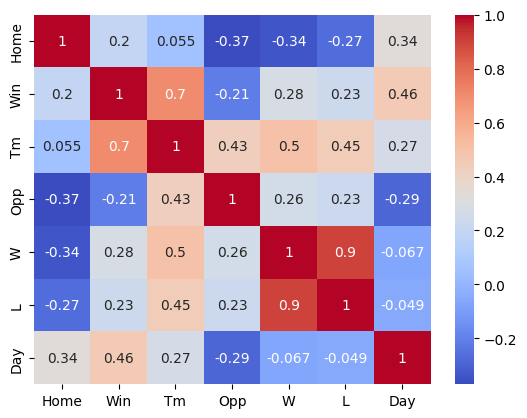

In [143]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True, cmap="coolwarm")